This notebook shows how to reproduce the results of the paper "Cosmic evolution of the incidence of Active Galactic Nuclei in massive clusters: Simulations versus observations". In concrete the fraction of AGNs at different redshifts (Table 2 and Figure 6 of the paper). The dataset consist in a collection of light cones at three different redshifts ($z=0.2,0.75$ and 1.25) generated for different massive clusters (above 10$^{14}$ M$_\odot$) from cosmological simulations. The tables are in hdf5 format and they can be found at https://zenodo.org/record/7193557. The relevant information about the content information of the dataset can be found on the README.pdf.

**CAUTION**: We recommend to create a python environment to run this notebook and avoid possible package conflicts. The requirements can be found in the file `requirements.yml`. An environment can be created with conda using `conda env create -f requirements.yml &`. The environment can be activated typing `conda activate condaEnvMock`

# Imports 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import glob
logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

import numpy as np
import pandas as pd
pd.set_option('max_columns', None)

import calc_frac_paper.calc_frac_agns_new as calc_frac_agns

from tqdm import tqdm 

# Selection effect thresholds

In the next block of code we define the thresholds used to select galaxies as members of the cluster or not. This selection mimics the one in observations (see Section 3.4 of the paper). We define the redshifts of the objects, the photometric bands and their magnitudes thresholds. We also define a magnitude threshold that is not present in observations. This is used to check the impact on the models that assigns magnitudes. The last variables defines a dictionary that will be ued to store the result for the two different specific accretion rate distributions used to seed galaxies with AGNs

In [3]:
z_martini = [1.25, 0.75, 0.2]
bands_martini = ['IRAC1', 'R_PRIME', 'R_PRIME']
m_cut_list = [18.5, 23.3, 19.11] #apparent magnitude cut
lgM_smCut = 10.7 - .4 #stellar mass cut
mask_xrlumi_dict = { 'AMedian': [],
                     'GMedian' : [] }

# Read files 

In this section we read the catalogues using `pandas` library. 

In [4]:
path_files = './input/'
names = sorted(glob.glob(f'{path_files}/lc_resample_reseed_?.????.h5'))
names

['./input/lc_resample_reseed_0.4505.h5',
 './input/lc_resample_reseed_0.5747.h5',
 './input/lc_resample_reseed_0.8376.h5']

In [5]:
lc_catalogue_concat_martini_reseed = [pd.read_hdf(file, 'df') for file in names ] 
lc_catalogue_concat_martini_reseed[0]

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,id,upid,vmp,v,r,sfr,obs_sfr,lgmp,lgm,lgsm,lgobs_sm,lgLxGMedian,SF,lgLxAMedian,dist_obs,x_rot,vx_rot,y_rot,vy_rot,z_obs_rot,vz_rot,final_redshift,angle_los,FOV,r_parent,id_obs,delta_redshift_lim,delta_redshift,lgssfr,Schreiber,SF_Schreiber,IRAC1_qUM,IRAC1_SFRq_remap,reseed,id_clust_reseed,lgssfr_q_remap
0,6674993942,-1,1539.530029,1539.530029,1715.423950,0.082825,0.137074,14.548070,14.548070,11.382639,11.361619,39.627632,2,35.901287,2692.747070,1165.993652,267.876404,2019.560303,-393.984467,1346.373535,185.408920,1.252066,0.000000,0.000638,762.410645,6674993942,0.01501,0.002066,-12.224664,-10.308075,False,17.347876,16.016893,0,6674993942_0,-10.708158
1,47000000372627036,6674993942,319.959991,302.246216,57.146717,0.033900,0.056104,11.877492,10.115931,10.665465,10.935956,42.431149,2,35.465405,2693.086670,1166.108276,690.808350,2020.162476,127.873199,1346.050171,-27.625000,1.255817,0.000201,0.000638,762.410645,6674993942,0.01501,0.005817,-12.186960,-10.180376,False,18.387181,17.089085,0,6674993942_0,-10.378029
2,40000000803853019,6674993942,352.609985,173.823532,77.162483,0.028167,0.046616,12.057323,10.507175,10.814270,10.688369,39.002815,2,35.028046,2692.912109,1165.737427,334.440552,2019.965820,-196.886780,1346.317383,834.766174,1.255947,0.000151,0.000638,762.410645,6674993942,0.01501,0.005947,-12.019838,-10.106100,False,19.018125,17.473718,0,6674993942_0,-10.727871
3,35000001250129460,6674993942,316.429993,347.001160,106.602921,0.292290,0.483735,12.096736,10.928265,10.794828,10.635340,39.964352,2,35.115688,2692.424072,1165.926270,-313.653748,2019.548584,1635.995605,1345.803467,342.985199,1.261985,0.000158,0.000638,762.410645,6674993942,0.01501,0.011985,-10.950732,-10.090191,False,19.066079,17.978963,0,6674993942_0,-10.520950
4,29000001935650071,6674993942,463.760010,316.336182,161.182510,0.075941,0.125680,12.626976,11.466911,10.633073,10.482882,39.444096,2,40.010021,2693.028564,1165.432251,-497.009644,2020.578735,1315.545410,1345.894531,139.455597,1.259237,0.000409,0.000638,762.410645,6674993942,0.01501,0.009237,-11.383614,-10.044454,False,19.505358,18.103327,0,6674993942_0,-10.330298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40835,6791595014,-1,202.850006,199.110001,221.914993,37.321640,61.766655,11.893657,11.883519,10.231270,10.366967,38.515804,1,35.053120,2692.399902,1166.432373,-484.396545,2019.938721,-239.499512,1344.730835,1713.269043,1.255983,0.000569,0.000617,737.795105,6791595263,0.01501,0.005983,-8.576213,-10.009679,True,17.962366,18.493182,9,6791595263_9,-9.076103
40836,6791597057,-1,154.240005,133.470001,156.449005,1.953050,3.232263,11.435334,11.428070,9.503747,9.485697,38.349518,1,34.064571,2709.316406,1173.409546,-396.708710,2031.388672,-530.259644,1355.346802,-276.950714,1.258799,0.000313,0.000617,737.795105,6791595263,0.01501,0.008799,-8.976191,-9.971726,True,20.702374,20.702374,9,6791595263_9,-9.082949
40837,6791597059,-1,287.140015,268.890015,326.776001,0.065745,0.108807,12.415191,12.387711,10.709394,10.616418,39.220734,2,35.440025,2707.779785,1172.260254,-339.471863,2030.868286,-395.302521,1354.049927,-136.114929,1.259222,0.000097,0.000617,737.795105,6791595263,0.01501,0.009222,-11.579760,-10.084515,False,19.188947,17.660592,9,6791595263_9,-10.583001
40838,6791597062,6791597059,153.509995,122.620003,115.703003,3.450493,5.710505,11.497800,11.034989,9.549514,9.196685,40.311901,1,33.560867,2707.874756,1172.451050,-468.703918,2030.900269,-547.319031,1354.026733,-184.511993,1.257822,0.000043,0.000617,737.795105,6791595263,0.01501,0.007822,-8.440010,-9.971726,True,20.750950,21.769165,9,6791595263_9,-9.105690


# Fraction calculation

Next block of code calculates the AGN fractions for 100 cluster subsamples drawn from the initial cluster sample  with replacement. The number of cluster in each subsample is the same as in the initial sample, i.e. 3880,
1570, 180 for $z$ = 0.2, 0.75 and 1.25 respectively. This is used to calculate the mean fractions and the error on the mean. The process works as follows:

+ For each light cone the number of galaxies/agn members are calculated. 
+ Then subsamples with replacement are created
+ The number of galaxies/AGN for all the clusters in teh subsample are summed and from there the fraction for the subsample is calculated

At the end of the process we have 100 fractions for each redshift from there we calculate the mean and the standard error 

In [6]:
df_frac_reseed_SFR_UMsf_AGEq = {'llx':[],
                                'hlx':[]}
lx_lim_lst = [43, 44] 

for loop_lx, lx in enumerate(df_frac_reseed_SFR_UMsf_AGEq):
    print(lx_lim_lst[loop_lx])
    for loop_martini, lc_catalogue in enumerate(lc_catalogue_concat_martini_reseed):
        mask_q = np.array(lc_catalogue.SF_Schreiber == False)
        lc_catalogue[f'{bands_martini[loop_martini]}'] = \
                                                lc_catalogue[f'{bands_martini[loop_martini]}_qUM']
        lc_catalogue.loc[mask_q, f'{bands_martini[loop_martini]}'] =  lc_catalogue[mask_q][f'{bands_martini[loop_martini]}_SFRq_remap']
        df_frac_reseed_SFR_UMsf_AGEq [f'{lx}'].append(calc_frac_agns.get_resample_reseed_summed(lc_catalogue, 
                                                                               mask_xrlumi_dict,
                                                                               m_cut_list[loop_martini], 
                                                                               f'{bands_martini[loop_martini]}', 
                                                                               lx_lim_lst[loop_lx], 
                                                                               lgM_smCut))

43


INFO:calc_frac_paper.calc_frac_agns_new:Resampling clusters with default realizations
INFO:calc_frac_paper.calc_frac_agns_new:hi default
INFO:calc_frac_paper.calc_frac_agns_new:Generating 100 random realizations:OOOOOOOOOOOOO
INFO:calc_frac_paper.calc_frac_agns_new:Resampling clusters with default realizations
INFO:calc_frac_paper.calc_frac_agns_new:hi default
INFO:calc_frac_paper.calc_frac_agns_new:Generating 100 random realizations:OOOOOOOOOOOOO
INFO:calc_frac_paper.calc_frac_agns_new:Resampling clusters with default realizations
INFO:calc_frac_paper.calc_frac_agns_new:hi default
INFO:calc_frac_paper.calc_frac_agns_new:Generating 100 random realizations:OOOOOOOOOOOOO


44


INFO:calc_frac_paper.calc_frac_agns_new:Resampling clusters with default realizations
INFO:calc_frac_paper.calc_frac_agns_new:hi default
INFO:calc_frac_paper.calc_frac_agns_new:Generating 100 random realizations:OOOOOOOOOOOOO
INFO:calc_frac_paper.calc_frac_agns_new:Resampling clusters with default realizations
INFO:calc_frac_paper.calc_frac_agns_new:hi default
INFO:calc_frac_paper.calc_frac_agns_new:Generating 100 random realizations:OOOOOOOOOOOOO
INFO:calc_frac_paper.calc_frac_agns_new:Resampling clusters with default realizations
INFO:calc_frac_paper.calc_frac_agns_new:hi default
INFO:calc_frac_paper.calc_frac_agns_new:Generating 100 random realizations:OOOOOOOOOOOOO


# Fraction results

The next block of code shows the fractions calculated above for different selection effects. It is equivalent to Table 2 of the paper. Note that the process above is random and thereforethere will be slight deviations from the values quoted in the paper. 

In [8]:
for loop_martini, z in enumerate(z_martini):
    print(f'{z}')
    for mask_xrlumi in ['GMedian', 'AMedian']:
        print(f'\t{mask_xrlumi}')
        for sample in ['sm', 'mag']:
            mean = df_frac_reseed_SFR_UMsf_AGEq['hlx'][loop_martini][f'f_{sample}_{mask_xrlumi}'].mean()
            ue = df_frac_reseed_SFR_UMsf_AGEq['hlx'][loop_martini][f'f_{sample}_{mask_xrlumi}'].quantile(q=.84) - mean
            le = mean - df_frac_reseed_SFR_UMsf_AGEq['hlx'][loop_martini][f'f_{sample}_{mask_xrlumi}'].quantile(q=.16)
            print(f'\t\t{sample}(lx>44): {mean:.5f} + {ue:.5f} - {le:.5f}')
            
            
            mean = df_frac_reseed_SFR_UMsf_AGEq['llx'][loop_martini][f'f_{sample}_{mask_xrlumi}'].mean()
            ue = df_frac_reseed_SFR_UMsf_AGEq['llx'][loop_martini][f'f_{sample}_{mask_xrlumi}'].quantile(q=.84) - mean
            le = mean - df_frac_reseed_SFR_UMsf_AGEq['llx'][loop_martini][f'f_{sample}_{mask_xrlumi}'].quantile(q=.16)
            
            print(f'\t\t{sample}(lx>43): {mean:.5f} + {ue:.5f} - {le:.5f}')
        print()

1.25
	GMedian
		sm(lx>44): 0.00345 + 0.00045 - 0.00053
		sm(lx>43): 0.03037 + 0.00149 - 0.00146
		mag(lx>44): 0.00326 + 0.00042 - 0.00043
		mag(lx>43): 0.02940 + 0.00152 - 0.00157

	AMedian
		sm(lx>44): 0.00293 + 0.00049 - 0.00049
		sm(lx>43): 0.03394 + 0.00133 - 0.00161
		mag(lx>44): 0.00274 + 0.00047 - 0.00049
		mag(lx>43): 0.03245 + 0.00142 - 0.00158

0.75
	GMedian
		sm(lx>44): 0.00084 + 0.00006 - 0.00006
		sm(lx>43): 0.01525 + 0.00028 - 0.00027
		mag(lx>44): 0.00054 + 0.00004 - 0.00005
		mag(lx>43): 0.01020 + 0.00023 - 0.00020

	AMedian
		sm(lx>44): 0.00065 + 0.00006 - 0.00006
		sm(lx>43): 0.01237 + 0.00024 - 0.00028
		mag(lx>44): 0.00037 + 0.00004 - 0.00004
		mag(lx>43): 0.00651 + 0.00016 - 0.00014

0.2
	GMedian
		sm(lx>44): 0.00090 + 0.00004 - 0.00004
		sm(lx>43): 0.00306 + 0.00006 - 0.00007
		mag(lx>44): 0.00077 + 0.00004 - 0.00004
		mag(lx>43): 0.00267 + 0.00006 - 0.00005

	AMedian
		sm(lx>44): 0.00039 + 0.00003 - 0.00003
		sm(lx>43): 0.00343 + 0.00009 - 0.00009
		mag(lx>44): 0

# Plot 

In this section is reproduced Figure 6 of the paper. First we define some initial parameters that make the plot look nice.

In [9]:
def plot_martini_result(ax, mew=6, cs=20, ms=10, dz_plot=0.02, elinewidth=6,
                         capthick=22, pathIn='/storage/ivan/', shift=4):
    shift = 0
    file = './input/frac_agns_results_martini.dat'
    columns = ['z', 'f_43', 'eu43', 'el43', 'f_44', 'eu44', 'el44']
    df_results_martini = pd.read_table(file, header=None, delimiter='\s+', names=columns,comment='#')
    #lx43 z=1.25 lower limit
    #lx44 z=0.25 upper limit
    for z in df_results_martini['z'].unique():
        llim = False
        ulim = False
        
        if z==1.25:
            llim=True
            cs_aux = cs - 8
        else:
            cs_aux = cs
            
        mask_z = df_results_martini.z==z

        ax.errorbar(z - shift*dz_plot, float(df_results_martini[mask_z]['f_43']),
                    yerr=np.array([ df_results_martini[mask_z]['el43'],   
                                    df_results_martini[mask_z]['eu43'] ]),
                    marker='*',
                    markeredgecolor='k',
                    markeredgewidth=mew-1,
                    alpha=1,
                    elinewidth=elinewidth,
                    lolims=llim,
                    capsize=cs_aux-1,
                    markersize=ms+10,
                    color='tab:red'
                   ) 
        
        if z == 0.2:
            ulim=True
            cs_aux = cs - 8
        else:
            cs_aux = cs
        ax.errorbar(z - (shift+2)*dz_plot, df_results_martini[mask_z]['f_44'],
                    yerr=np.array([ df_results_martini[mask_z]['el44'],
                                    df_results_martini[mask_z]['eu44'] ]),
                    marker='*',
                    markeredgecolor='k',
                    markeredgewidth=mew-1,
                    alpha=1,
                    elinewidth=elinewidth,
                    capsize=cs_aux,
                    capthick=capthick+1000,
                    uplims=ulim,
                    markersize=ms+10,
                    color='tab:blue'
                    ) 

In [10]:
marker_dict = {'GMedian':'o', 
               'AMedian':'d'}
color_dict = {'AMedian':'tab:blue', 
              'GMedian':'tab:orange'}
ls_dict = {'AMedian':'-', 
           'GMedian':'-.'}

titles = ['Stellar mass selected sample', 'Magnitude selected sample']

color_lumi = ['tab:red',
              'tab:blue']

marker_model = ['o', 'd']
lx_trhes = ['llx', 'hlx']

dz_plot = 0.02
fs = 20
ms = 26
cs = 16
mew = 6
elw = 6
alpha = .8
dz_plot=0.02

In [11]:
def plot_legend(ax, ms):
    ax.errorbar([],[],
                marker='s',
                markersize=ms-4,
                lw=0,
                color='tab:red',
                label='lgL$_{x}$>43')
    ax.errorbar([],[],
                marker='s',
                markersize=ms-4,
                lw=0,
                color='tab:blue',
                label='lgL$_{x}$>44')
    ax.errorbar([],[],
                marker='X',
                lw=0,
                color='white',
                label='SAR models:')     
    ax.plot([],[],
            ls=ls_dict['GMedian'],
            lw=4,
            color='k',
            label='Georgakakis et al. +17')
    ax.plot([],[],
            ls=ls_dict['AMedian'],
            lw=4,
            color='k',
            label='Aird et al. +18')
    ax.errorbar([],[],
                marker='X',
                lw=0,
                color='white',
                label='Observations:')
    ax.errorbar([],[],
                marker='*',
                markersize=ms-4,
                lw=0,
                color='k',
                label='Martini+13')

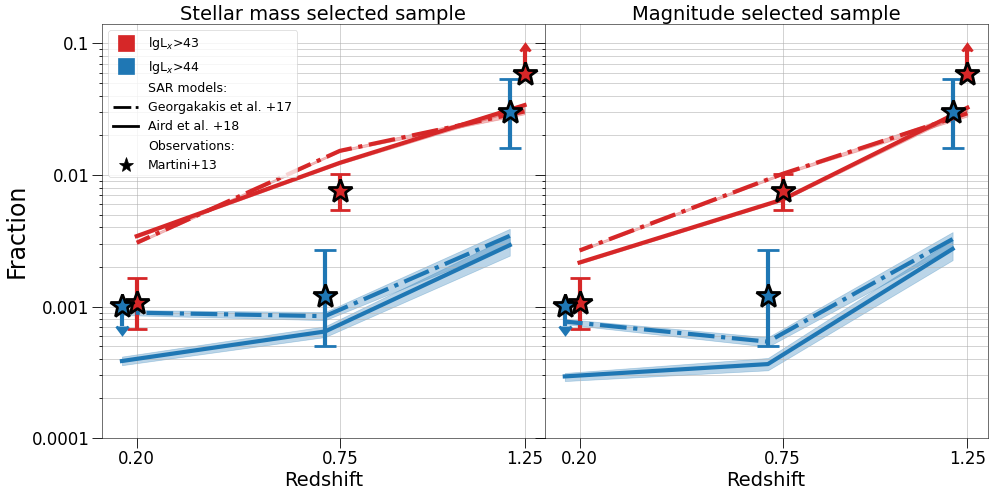

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[20, 10], dpi=50, sharey='col')

for col, selection in enumerate(['sm', 'mag']):
    for loop_model, mask_xrlumi in enumerate(['GMedian', 'AMedian']):
        for loop_lx, lx in enumerate(['llx', 'hlx']):
            mean = []
            le = []
            ue = []
            for loop_martini, z in enumerate(z_martini):
                mean_aux = df_frac_reseed_SFR_UMsf_AGEq[f'{lx}'][loop_martini][f'f_{selection}_{mask_xrlumi}'].mean()
                mean.append( mean_aux )
                le.append( df_frac_reseed_SFR_UMsf_AGEq[f'{lx}'][loop_martini][f'f_{selection}_{mask_xrlumi}'].quantile(q=.16) )
                ue.append( df_frac_reseed_SFR_UMsf_AGEq[f'{lx}'][loop_martini][f'f_{selection}_{mask_xrlumi}'].quantile(q=.84) )
            if lx == 'llx':
                shift = 0
            else:
                shift = 2
            ax[col].plot(np.array(z_martini) - shift*dz_plot,
                          mean,
                          lw=6,
                          ls=ls_dict[mask_xrlumi],
                          color=color_lumi[loop_lx]
                         )

            ax[col].fill_between(np.array(z_martini) - shift*dz_plot, ue, le, 
                                 alpha=0.3,
                                 color=color_lumi[loop_lx])
                    
    

    plot_martini_result(ax[col], mew=mew-1, cs=cs, ms=ms, shift=0)
    plot_legend(ax[col], ms)
    
    ax[col].set_ylim(0.0001, .14)
    ax[col].set_yscale('log')
    ax[col].yaxis.set_major_formatter(StrMethodFormatter('{x:.4}'))
    ax[col].tick_params(axis = 'both', which = 'major', labelsize = fs)
    ax[col].set_xlabel('Redshift', fontsize=fs+8)

    ax[col].grid(True, which="both", ls="-")
    ax[col].set_title(f'{titles[col]}', fontsize=fs+8)
    if col == 0:
        #get handles and labels
        handles, labels = ax[col].get_legend_handles_labels()
        #specify order of items in legend
        order = [2, 3, 4, 0, 1, 5, 6]
        #add legend to plot
        ax[col].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=fs-2)
        
    if col == 1:
        ax[col].set(yticklabels=[])
    else:
        ax[col].set_ylabel('Fraction', fontsize=fs+14)
    
    ax[col].set_xticks([0.2, .75, 1.25 ])
    ax[col].xaxis.set_tick_params(which='major', width=1.2, size=14, labelsize=24, bottom=True)
    ax[col].yaxis.set_tick_params(which='major', width=1.2, size=14, labelsize=24, left=True)
    ax[col].xaxis.set_tick_params(which='minor', width=1.2, size=4, bottom=True)
    ax[col].yaxis.set_tick_params(which='minor', width=1.2, size=4, left=True)
    
fig.tight_layout()
fig.subplots_adjust(wspace=0)

plt.show()